In [1]:
# !pip install -q -U lightautoml

In [5]:
from functools import cache
from ast import literal_eval
import os
import re

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import quantile_transform
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score

# Download and prepare dataset

In [6]:
evals = ['author', 'author_href', 'fandom', 'characters', 'genre', 'events', 'series',
       'warnings', 'beta', 'translator']
drops = [ 'fandom_href', 'characters_href', 'events_href', 'series_href',
       'beta_href', 'collections_href', 'translator_href']
fics = pd.read_csv('metadata_fics_clean.csv', converters={col: literal_eval for col in evals})
fics = fics.drop(columns=drops)
fics['summary'] = fics.summary.fillna('')
fics.head(1)

,id,error,name,type,summary,author,author_href,fandom,characters,rating,...,warnings,beta,translator,size_type,MB,n_words,k_simbols,n_pages,date_from,date_to
0,172221,False,Сны о путешествиях,джен,"Элли скучала, сидя за партой. Скучала, страдая...",[Almalgara Termallion],[/user283381],[Ориджиналы],[Новый Женский Персонаж],General,...,[],[],[],Мини,6,996,6,4,2022/01/27,2022/01/27


In [7]:
pat = re.compile('(\d+)')
def proces_href(line, pat=pat):
    return pat.search(line).group()

In [8]:
auth = pd.read_csv('authors.csv')
auth.head(1)

cts = pd.DataFrame()
cts['text_id'] = fics['id']
cts['auth_id'] = fics.author_href.apply(lambda x: [proces_href(el) for el in x])
cts['simb'] = fics['k_simbols']
cts = cts.explode('auth_id')
cts = cts.groupby('auth_id', as_index=False).agg({'text_id': 'count', 'simb': 'sum'})

auth['id'] = auth['id'].astype(str)
auth = auth.merge(cts, left_on='id', right_on='auth_id').drop(columns=['auth_id'])
auth = auth.reset_index(drop=True)

In [9]:
def acad_conv(line):
    if 'высш' in line.lower():
        return 2
    elif 'средне' in line.lower():
        return 1
    else:
        return 0

In [10]:
auth.text_id.describe()

count    5509.000000
mean        6.009439
std        16.092369
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       498.000000
Name: text_id, dtype: float64

In [11]:
auth.simb.describe()

count     5509.000000
mean       499.068252
std       1191.842814
min          0.000000
25%         24.000000
50%        101.000000
75%        451.000000
max      35529.000000
Name: simb, dtype: float64

SignificanceResult(statistic=nan, pvalue=nan)


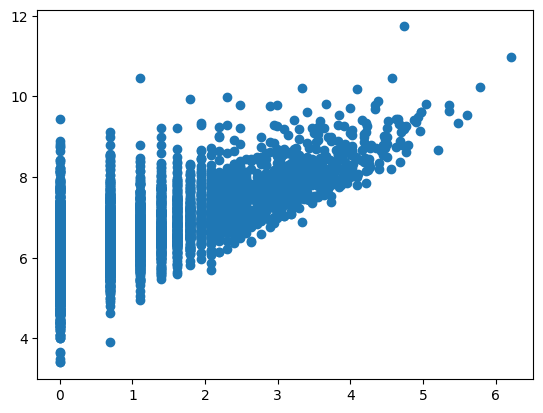

In [12]:
print(stats.spearmanr(auth.text_id, auth['Рейтинг']))
plt.scatter(np.log(auth.text_id), np.log(auth['Рейтинг']));

SignificanceResult(statistic=nan, pvalue=nan)


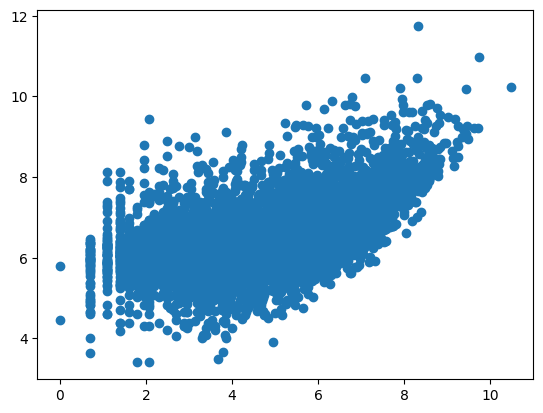

In [13]:
print(stats.spearmanr(auth.simb, auth['Рейтинг']))
plt.scatter(np.log(auth.simb), np.log(auth['Рейтинг']));

SignificanceResult(statistic=0.5715265675440755, pvalue=0.0)


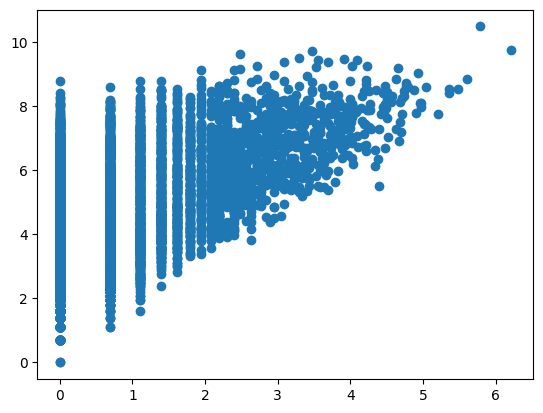

In [14]:
print(stats.spearmanr(auth.text_id, auth.simb))
plt.scatter(np.log(auth.text_id), np.log(auth.simb));

In [15]:
auth.loc[auth['Подписан'].isna() & -auth['Подписана'].isna(), 'Подписан'] = auth.loc[auth['Подписан'].isna() & -auth['Подписана'].isna(), 'Подписана']
auth['Подписан'] = auth['Подписан'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
auth['Личный сайт'] = (-auth['Личный сайт'].isna()).astype(int)

targets = []
text_cols = ['Любимые фильмы', 'Любимые книги', 'Начал читать', 'Начал писать', 'Первый фанфик',
       'Любимые персонажи', 'Любимые пейринги', 'Любимая категория',
       'Деятельность', 'Писать', 'Переводить', 'Рисовать',
        'Род деятельности', 'Любимые аниме', 'Любимая музыка', 'Любимые игры', 'Интересы',
     'Любимые комиксы', 'Любимые мюзиклы', 'Любимые аудиопостановки', 'Озвучивать']
skip = ['Email', 'Skype', 'Unnamed: 21', 'id', 'Дата рождения', 'Зарегистрирован', 'Звание',
 'Предыдущий ник', 'Реальное имя', 'Создавал', 'Создавала', 'Рейтинг', 'text_id', 'Привел друзей', 'simb']
categ = ['Образование', 'Откуда', 'Пол', 'Подписан']
flag = ['Личный сайт']

target = auth['simb']

auth[text_cols] = auth[text_cols].fillna('')
auth[categ] = auth[categ].fillna('')
auth[flag] = auth[flag].fillna(0)
auth[targets] = auth[targets].fillna(0)

auth['text'] = ''
for col in text_cols:
    auth['text'] += ' ' + auth[col]

gender = auth['Пол'].apply(lambda x: int(x == 'женский')).to_numpy()
acad = auth['Образование'].apply(acad_conv).to_numpy()
site = auth['Личный сайт'].to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')
origin = enc.fit_transform(auth[['Откуда']]).toarray()

enc_sub = CountVectorizer(max_features=1000)
subscr = enc_sub.fit_transform(auth['Подписан'].apply(lambda x: ' '.join([el.replace(' ', '#') for el in x]))).toarray()

vectorizer = TfidfVectorizer(lowercase=True, max_features=1000)
text = vectorizer.fit_transform(auth['text']).toarray()

In [16]:
features = np.hstack([np.array(['gender', 'learning', 'site']), enc.get_feature_names_out(),
                      enc_sub.get_feature_names_out(), vectorizer.get_feature_names_out()])

In [17]:
data = np.hstack([gender.reshape(-1, 1), acad.reshape(-1, 1), site.reshape(-1, 1), origin, subscr, text])
target = target.to_numpy()
y_trans = quantile_transform(target.reshape(-1, 1), n_quantiles=900, output_distribution="normal", copy=True).squeeze()

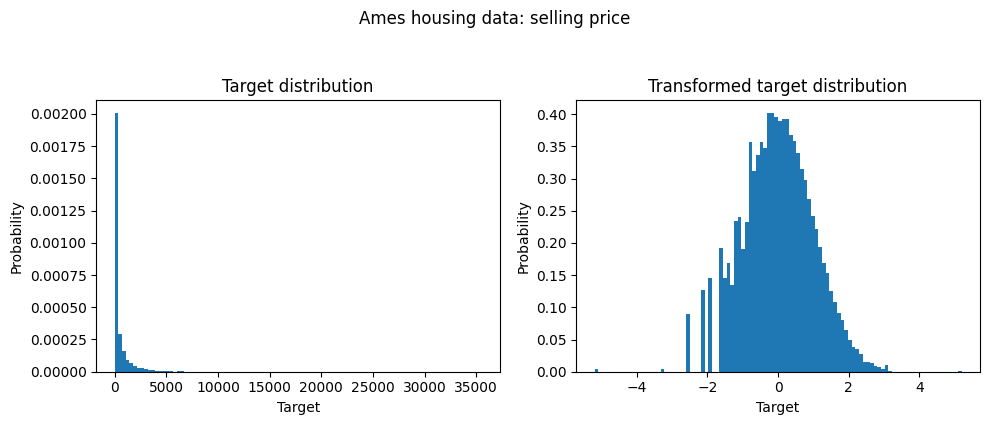

In [18]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ax0.hist(target, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, y_trans, test_size=0.2, random_state=42, shuffle=True)

# Simple models for regression task for k_simbols

In [17]:
gbr = GradientBoostingRegressor(random_state=0)
scores = cross_val_score(gbr, data, y_trans, cv=5, verbose=5)
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.042) total time= 1.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.019) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=0.035) total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min remaining:    0.0s


[CV] END ................................ score: (test=0.035) total time= 1.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.5min remaining:    0.0s


[CV] END ................................ score: (test=0.049) total time= 1.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished


array([0.04172345, 0.01944492, 0.03477041, 0.03500771, 0.04933936])

In [18]:
def evaluate(esti, x, xev, y, yev):
    esti.fit(x, y)

    pred_train = esti.predict(x)
    pred_test = esti.predict(xev)

    metrics = {'MSE': mean_squared_error, 'R2': r2_score, 'EVS': explained_variance_score,
               'MAE' : mean_absolute_error,'MAPE' : mean_absolute_percentage_error}
    res = {'train': {}, 'test': {}}
    for mname, metric in metrics.items():
        res['train'][mname] = metric(y, pred_train)
        res['test'][mname] = metric(yev, pred_test)
    return res

In [19]:
gbr = GradientBoostingRegressor(random_state=0)
evaluate(gbr, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.7872043157345882,
  'R2': 0.207689500205401,
  'EVS': 0.2076895002054009,
  'MAE': 0.709807819520674,
  'MAPE': 1.232563218525643},
 'test': {'MSE': 1.0012231557987572,
  'R2': 0.03700172460022488,
  'EVS': 0.04800550019690186,
  'MAE': 0.8024317949146735,
  'MAPE': 1.745212172808324}}

In [20]:
linreg = LinearRegression()
evaluate(linreg, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.3696212252520819,
  'R2': 0.6279812345275464,
  'EVS': 0.6279812349810993,
  'MAE': 0.39861345617237215,
  'MAPE': 1.3625460858721026},
 'test': {'MSE': 9.013799540993797e+23,
  'R2': -8.669669056796185e+23,
  'EVS': -8.669402611265157e+23,
  'MAE': 73219207775.73428,
  'MAPE': 181847259690.77313}}

In [21]:
knn = KNeighborsRegressor()
evaluate(knn, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.8386901517343224,
  'R2': 0.15586970242491505,
  'EVS': 0.17023817567850308,
  'MAE': 0.7247071204605917,
  'MAPE': 2.143540894626658},
 'test': {'MSE': 1.2462644037143524,
  'R2': -0.19868429382418018,
  'EVS': -0.1267886182092055,
  'MAE': 0.8949438713450669,
  'MAPE': 2.9778538617163157}}

In [22]:
rfr = RandomForestRegressor()
evaluate(rfr, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.33499315812234925,
  'R2': 0.6628339158786096,
  'EVS': 0.6628389375393756,
  'MAE': 0.41325161896122975,
  'MAPE': 0.8883051995985475},
 'test': {'MSE': 1.0255465850640895,
  'R2': 0.013606919657228267,
  'EVS': 0.02275862459662159,
  'MAE': 0.7984098437305912,
  'MAPE': 2.3165526950651323}}

In [23]:
gbr.feature_importances_.argsort()[:-10:-1]

array([   1, 2768, 2010, 2037,  705, 2233, 2176, 1537, 2520])

In [24]:
features[gbr.feature_importances_.argsort()[:-10:-1]]

array(['learning', 'слэш', 'https', 'автор', 'Откуда_Слоним', 'джен',
       'гет', 'лавкрафта', 'назад'], dtype=object)

# Try some strong ml pipelines from sber Light Automl Framework

In [20]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import seaborn as sns

## Dataset preporation

In [21]:
# prepare datasets and split into train/test
# Do it with the beginning because remake some trasformation with features

# define features
evals = ['author', 'author_href', 'fandom', 'characters', 'genre', 'events', 'series',
       'warnings', 'beta', 'translator']
drops = ['fandom_href', 'characters_href', 'events_href', 'series_href',
       'beta_href', 'collections_href', 'translator_href']
text_cols = ['Любимые фильмы', 'Любимые книги', 'Начал читать', 'Начал писать', 'Первый фанфик',
       'Любимые персонажи', 'Любимые пейринги', 'Любимая категория',
       'Деятельность', 'Писать', 'Переводить', 'Рисовать',
        'Род деятельности', 'Любимые аниме', 'Любимая музыка', 'Любимые игры', 'Интересы',
     'Любимые комиксы', 'Любимые мюзиклы', 'Любимые аудиопостановки', 'Озвучивать']
skip = ['Email', 'Skype', 'Unnamed: 21', 'id', 'Дата рождения', 'Зарегистрирован', 'Звание',
 'Предыдущий ник', 'Реальное имя', 'Создавал', 'Создавала', 'Рейтинг', 'text_id', 'Привел друзей', 'simb']
categ = ['Образование', 'Откуда', 'Пол', 'Подписан']

targets = ['simb','rating','invite_friends']
# download and prepare datasets
fics = pd.read_csv('metadata_fics_clean.csv', converters={col: literal_eval for col in evals}) \
            .drop(columns=drops) \
            .fillna({'summary':''})

auth = pd.read_csv('authors.csv').astype({'id':str})
cts = pd.DataFrame()
cts['text_id'] = fics['id']
cts['auth_id'] = fics.author_href.apply(lambda x: [proces_href(el) for el in x])
cts['simb'] = fics['k_simbols']
cts = cts.explode('auth_id')
cts = cts.groupby('auth_id', as_index=False).agg({'text_id': 'count', 'simb': 'sum'})
auth = auth.merge(cts, left_on='id', right_on='auth_id').drop(columns=['auth_id']).reset_index(drop=True)

auth.loc[auth['Подписан'].isna() & -auth['Подписана'].isna(), 'Подписан'] = auth.loc[auth['Подписан'].isna() & -auth['Подписана'].isna(), 'Подписана']
auth['Подписан'] = auth['Подписан'].apply(lambda x: x.split(',') if isinstance(x, str) else x).fillna('')
auth['Личный сайт'] = (-auth['Личный сайт'].isna()).astype(int)
auth[text_cols] = auth[text_cols].fillna('')

auth['rating'] = auth['Рейтинг'].fillna(0)
auth['invite_friends'] = auth['Привел друзей'].map(lambda x: 1 if x > 0 else 0)

auth['text'] = ''
for col in text_cols:
    auth['text'] += ' ' + auth[col]

gender = auth['Пол'].apply(lambda x: int(x == 'женский')).to_numpy()
acad = auth['Образование'].astype(str).apply(acad_conv).to_numpy()
site = auth['Личный сайт'].to_numpy()
origin = auth['Откуда'].to_numpy()

enc_sub = CountVectorizer(max_features=1000)
subscr = enc_sub.fit_transform(auth['Подписан'].apply(lambda x: ' '.join([el.replace(' ', '#') for el in x]))).toarray()

vectorizer = TfidfVectorizer(lowercase=True, max_features=1000)
text = vectorizer.fit_transform(auth['text']).toarray()

# collect all features together
features = np.hstack([np.array(['gender', 'learning', 'site', 'origin']),
                      'enc_sub_' + enc_sub.get_feature_names_out(), 'tfidf_' + vectorizer.get_feature_names_out()])

categ = ['gender', 'learning', 'site', 'origin']
data = pd.DataFrame(np.hstack([gender.reshape(-1, 1), acad.reshape(-1, 1), site.reshape(-1, 1), origin.reshape(-1, 1), subscr, text]),
                    columns=features)
# adding targets and their quantile/log transform if regression task
for target_col in targets:
    if target_col != 'invite_friends':
      data[target_col] = auth[target_col].reset_index(drop=True)
      data[f'log_{target_col}'] = np.log1p(auth[target_col])
      data[f'quant_{target_col}'] = quantile_transform(data[target_col].values.reshape(-1, 1),
                                                       n_quantiles=900,
                                                       output_distribution="normal",
                                                       copy=True).squeeze()
    else:
      data[target_col] = auth[target_col].reset_index(drop=True)

# train/test split
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True,stratify=data['invite_friends'])

## Target Distribution

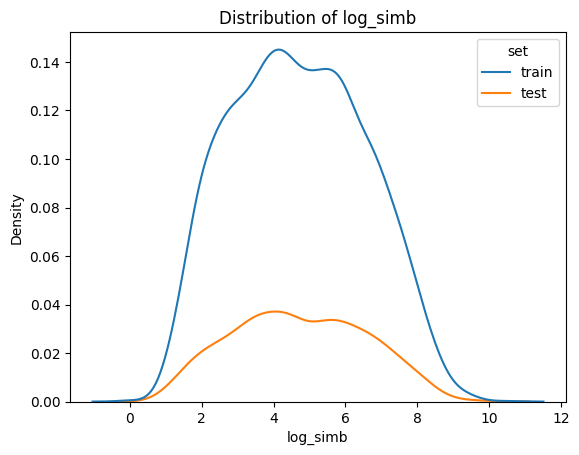

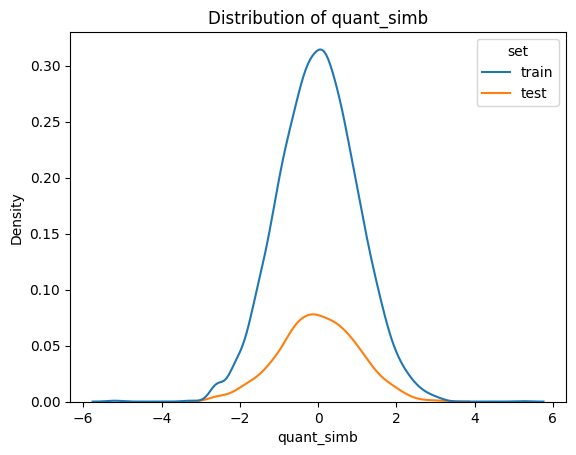

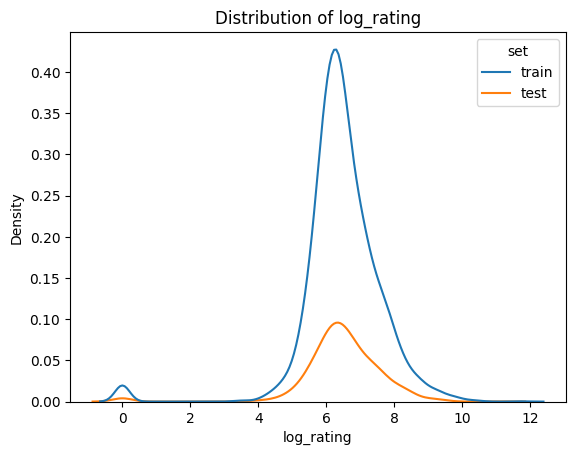

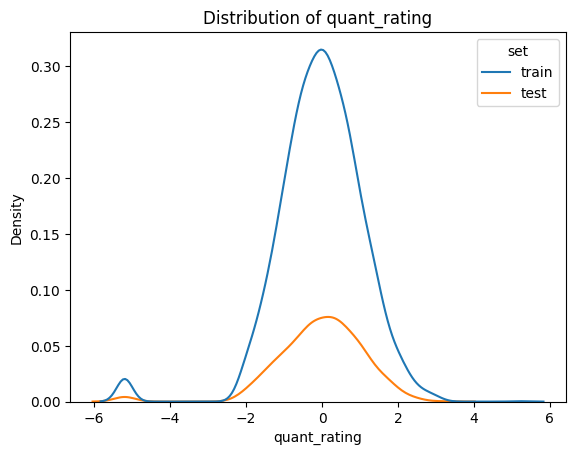

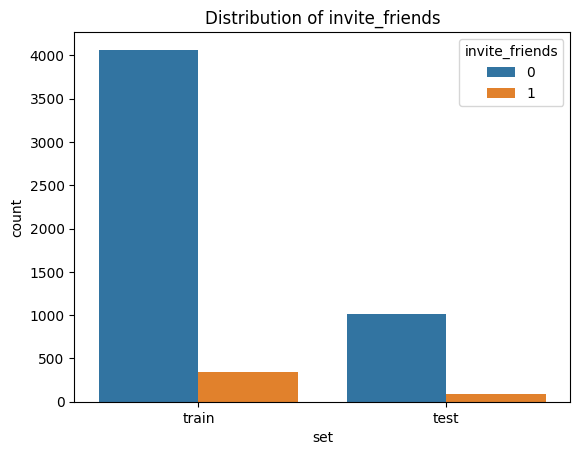

In [22]:
for target_col in ['log_simb','quant_simb','log_rating','quant_rating','invite_friends']:
    if target_col != 'invite_friends':
      tr = train.copy()
      tr['set'] = 'train'
      t = test.copy()
      t['set'] = 'test'
      sns.kdeplot(data = pd.concat([tr,t]),x = target_col,hue='set')
      plt.title(f'Distribution of {target_col}')
      plt.show()
    else:
      tr = train.copy()
      tr['set'] = 'train'
      t = test.copy()
      t['set'] = 'test'
      sns.countplot(data = pd.concat([tr,t]),x = 'set',hue=target_col)
      plt.title(f'Distribution of {target_col}')
      plt.show()

## Define models and params and fitting

In [ ]:
# some overall params
N_THREADS = 2
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600
ADVANCED_ROLES = False

# models placement
models = {
    'log_simb' : {
        'task' : Task(name='reg',loss='mae',metric='mape',greater_is_better=False),
        'roles': {'target': 'log_simb', 'drop': ['simb','quant_simb','rating', 'log_rating', 'quant_rating', 'invite_friends'],'category': categ},
          },
    'quant_simb' : {
        'task' : Task(name='reg',loss='mae',metric='mape',greater_is_better=False),
        'roles': {'target': 'quant_simb', 'drop': ['log_simb','simb', 'rating', 'log_rating', 'quant_rating', 'invite_friends'],'category': categ},
          },
    'log_rating' : {
        'task' : Task(name='reg',loss='mae',metric='mape',greater_is_better=False),
        'roles': {'target': 'log_rating', 'drop': ['simb', 'quant_simb', 'log_simb', 'quant_rating', 'rating', 'invite_friends'],'category': categ},
          },
    'quant_rating' : {
        'task' : Task(name='reg',loss='mae',metric='mape',greater_is_better=False),
        'roles': {'target': 'quant_rating', 'drop': ['simb', 'quant_simb', 'log_simb','rating', 'log_rating', 'invite_friends'],'category': categ},
          },
    'invite_friends' : {
        'task' : Task(name='binary'),
        'roles': {'target': 'invite_friends', 'drop': ['simb', 'quant_simb', 'rating', 'quant_rating','log_simb', 'log_rating'],'category': categ},
          },
}
# fitting models and saving results
for key,val in models.items():

    print('fitting model for',key)
    automl = TabularAutoML(
        task = val['task'],
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        general_params = {'use_algos': [[ 'lgb','cb','rf','cb_tuned','lgb_tuned']]},
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': ADVANCED_ROLES},
        selection_params = {'mode' : 1,'importance_type': 'permutation','fit_on_holdout': True,'cutoff': 0},
        tuning_params = {'max_tuning_iter' : 15}
    )
    train_pred = automl.fit_predict(train, roles = val['roles'],verbose = 1)
    train_pred = automl.predict(train)
    test_pred =  automl.predict(test)

    if key != 'invite_friends':
        metrics = {'MSE': mean_squared_error, 'R2': r2_score, 'EVS': explained_variance_score,
                  'MAE' : mean_absolute_error,'MAPE' : mean_absolute_percentage_error}

        models[key] = {'train': {}, 'test': {}}
        for mname, metric in metrics.items():
            models[key]['train'][mname] = metric(train[key], train_pred.data)
            models[key]['test'][mname] = metric(test[key], test_pred.data)

        models[key]['model'] = automl
    else:
        metrics = {'ROC-AUC': roc_auc_score, 'Precision': precision_score, 'Recall': recall_score, 'F1' : f1_score}

        models[key] = {'train': {}, 'test': {}}
        for mname, metric in metrics.items():
            if mname == 'ROC-AUC':
                models[key]['train'][mname] = metric(train[key], train_pred.data)
                models[key]['test'][mname] = metric(test[key], test_pred.data)
            else:
                models[key]['train'][mname] = metric(train[key], (train_pred.data > 0.2).astype(int))
                models[key]['test'][mname] = metric(test[key], (test_pred.data > 0.2).astype(int))

        models[key]['model'] = automl

fitting model for log_simb
[20:04:43] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[20:04:43] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[20:04:43] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[20:04:43] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[20:04:43] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[20:04:43] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[20:04:43] Train data shape: (4407, 2011)



INFO:lightautoml.reader.base:Train data shape: (4407, 2011)



[20:04:59] Layer 1 train process start. Time left 584.36 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 584.36 secs


[20:05:04] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'squared_error'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.449278
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.458184
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.442258
INFO2:lightautoml.ml_algo.b

[20:05:38] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -inf


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -inf


[20:05:38] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


[20:05:38] Time left 545.71 secs



INFO:lightautoml.automl.base:Time left 545.71 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's mape: 0.439529
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's mape: 0.43718
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's mape: 0.436824
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's mape: 0.435918
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's mape: 0.435237
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's mape: 0.434788
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's mape: 0.434683
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's mape: 0.43449
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's mape: 0.434045
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's mape: 0.433995
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's mape: 0.433605
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's mape: 0.433622
DEBUG:lightautoml.ml_algo.boost_lgbm:[1300]	valid's mape

[20:06:05] Selector_LightGBM fitting and predicting completed


Выходные данные были обрезаны до нескольких последних строк (5000).
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Start processing (1004,tfidf_10)
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Shuffled score for col tfidf_10 = -0.43514479259968436, difference with normal = -0.00026092805514832396
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Normal column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Start processing (1005,tfidf_11)
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Shuffled score for col tfidf_11 = -0.4354057206548327, diffe

[20:12:25] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's mape: 0.437323
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's mape: 0.431264
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's mape: 0.427714
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's mape: 0.425398
DEBUG:lightautoml.ml_algo.boost_lgbm:[500

[20:12:49] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[20:12:49] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.41297437998614117


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.41297437998614117


[20:12:49] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[20:12:50] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.4417673	test: 0.4486536	best: 0.4486536 (0)	total: 31ms	remaining: 1m 1s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.4164239	test: 0.4317414	best: 0.4316645 (99)	total: 1.24s	remaining: 23.2s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn:

[20:13:07] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[20:13:07] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.41886086107629106


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.41886086107629106


[20:13:07] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[20:13:07] Time left 96.90 secs



INFO:lightautoml.automl.base:Time left 96.90 secs



[20:13:07] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[20:13:07] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[20:13:07] Blending: optimization starts with equal weights and score -inf


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -inf


[20:13:07] Blending: iteration 0: score = -0.41297437998614117, weights = [0. 1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.41297437998614117, weights = [0. 1. 0.]


[20:13:07] Blending: iteration 1: score = -0.41297437998614117, weights = [0. 1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.41297437998614117, weights = [0. 1. 0.]


[20:13:07] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[20:13:07] Automl preset training completed in 503.18 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 503.18 seconds



[20:13:07] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



fitting model for quant_simb
[20:13:11] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[20:13:11] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[20:13:11] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[20:13:11] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[20:13:11] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[20:13:11] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[20:13:11] Train data shape: (4407, 2011)



INFO:lightautoml.reader.base:Train data shape: (4407, 2011)



[20:13:21] Layer 1 train process start. Time left 590.75 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 590.75 secs


[20:13:26] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'squared_error'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -1.201634
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -1.159080
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -1.340950
INFO2:lightautoml.ml_algo.b

[20:13:59] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -1.3345891766060967


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -1.3345891766060967


[20:13:59] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


[20:13:59] Time left 552.53 secs



INFO:lightautoml.automl.base:Time left 552.53 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's mape: 0.639906
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's mape: 0.635836
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's mape: 0.635601
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's mape: 0.635776
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[260]	valid's mape: 0.635209


[20:14:12] Selector_LightGBM fitting and predicting completed


Выходные данные были обрезаны до нескольких последних строк (5000).
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Start processing (1004,tfidf_10)
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Shuffled score for col tfidf_10 = -1.331707106404964, difference with normal = -0.00019089218431389554
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Normal column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Start processing (1005,tfidf_11)
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Shuffled score for col tfidf_11 = -1.3318979985892778, differe

[20:16:09] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's mape: 0.647284
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's mape: 0.644001
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's mape: 0.642786
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's mape: 0.642143
DEBUG:lightautoml.ml_algo.boost_lgbm:[500

[20:16:51] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[20:16:51] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.545280443498819


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.545280443498819


[20:16:51] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[20:16:51] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.6257819	test: 0.6561028	best: 0.6561028 (0)	total: 23.4ms	remaining: 46.9s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.5932665	test: 0.6470543	best: 0.6467961 (95)	total: 1.28s	remaining: 24.1s
DEBUG:lightautoml.ml_algo.boost_cb:200:	lear

[20:17:47] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.482677300944893


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.482677300944893


[20:17:47] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[20:17:47] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-697c1969-1e3a-47d2-b734-8457c07997ce
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.6258308	test: 0.6558433	best: 0.6558433 (0)	total: 11.6ms	remaining: 23.2s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.6002724	test: 0.6499994	best: 0.6498082 (68)	total: 894ms	remaining: 16.8s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 0.5823821	test: 0.6463725	best: 0.6462831 (195)	total: 1.89s	remaining: 17s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 0.5655181	test: 0.6448045	best: 0.6446908 (296)	total: 2.74s	remaining: 15.5s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 0.5506831	test: 0.6437429	best: 0.6437429 (400)	total: 3.76s	remaining: 15s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 0.5394402	test: 0.6437257	best: 0.6435049 (435)	total: 4.78s	remaining: 14.3s

[20:17:58] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4}
 achieve -1.6275 mape


[20:17:58] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 0.6260744	test: 0.6560014	best: 0.6560014 (0)	total: 6.17ms	remaining: 18.5s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.6082410	test: 0.6506764	best: 0.6505843 (68)	total: 800ms	remaining: 23s
DEBUG:lightautoml.ml_algo.boost_cb

[20:18:25] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.3237235455172314


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.3237235455172314


[20:18:25] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[20:18:25] Time left 286.44 secs



INFO:lightautoml.automl.base:Time left 286.44 secs



[20:18:25] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[20:18:25] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[20:18:25] Blending: optimization starts with equal weights and score -1.3432927221490407


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -1.3432927221490407


[20:18:25] Blending: iteration 0: score = -1.2983191656451423, weights = [0.4628966 0.        0.        0.5371035]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -1.2983191656451423, weights = [0.4628966 0.        0.        0.5371035]


[20:18:25] Blending: iteration 1: score = -1.2983191323915164, weights = [0.46250823 0.         0.         0.53749174]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -1.2983191323915164, weights = [0.46250823 0.         0.         0.53749174]


[20:18:25] Blending: iteration 2: score = -1.2983191323915164, weights = [0.46250823 0.         0.         0.53749174]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -1.2983191323915164, weights = [0.46250823 0.         0.         0.53749174]


[20:18:25] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[20:18:25] Automl preset training completed in 313.70 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 313.70 seconds



[20:18:25] Model description:
Final prediction for new objects (level 0) = 
	 0.46251 * (5 averaged models Lvl_0_Pipe_0_Mod_0_RFSklearn) +
	 0.53749 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.46251 * (5 averaged models Lvl_0_Pipe_0_Mod_0_RFSklearn) +
	 0.53749 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



fitting model for log_rating
[20:18:43] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[20:18:43] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[20:18:43] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[20:18:43] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[20:18:43] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[20:18:43] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[20:18:43] Train data shape: (4407, 2011)



INFO:lightautoml.reader.base:Train data shape: (4407, 2011)



[20:18:55] Layer 1 train process start. Time left 587.47 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 587.47 secs


[20:19:02] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'squared_error'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model:  -inf
INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model:  -inf
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
INFO2:lightautoml.ml_algo.random_forest:Score for RF model:  -inf
INFO2:lightautoml.ml_algo.base:===== St

[20:19:42] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -inf


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -inf


[20:19:42] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed


[20:19:42] Time left 540.99 secs



INFO:lightautoml.automl.base:Time left 540.99 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's mape: 0.158273
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's mape: 0.154632
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's mape: 0.153352
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's mape: 0.152694
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's mape: 0.152412
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's mape: 0.152279
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's mape: 0.152212
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's mape: 0.15219
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's mape: 0.152201
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's mape: 0.152205
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[811]	valid's mape: 0.152188


[20:20:19] Selector_LightGBM fitting and predicting completed


Выходные данные были обрезаны до нескольких последних строк (5000).
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Shuffled score for col enc_sub_мерлин = -inf, difference with normal = nan
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Normal column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Start processing (606,enc_sub_мертвецы)
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Shuffled score for col enc_sub_мертвецы = -inf, difference with normal = nan
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Normal column set
DEBUG:lightautoml.pipelines.selection.permutation_importance_based:Start processing (607,enc_sub_место)
INFO3:lightautoml.pipelines.selection.permutation_importance_based:Shuffled column set
INFO

## Metrics and Important features

In [ ]:
for key,val in models.items():
  print(key)
  print(val['model'].create_model_str_desc())
  print('Metrics')
  display(pd.DataFrame(val).drop(columns='model').T)
  print('Number of features:',len(val['model'].reader.used_features))
  accurate_fi = val['model'].get_feature_scores()
  # accurate_fi = val['model'].get_feature_scores('accurate', test, silent = True)
  accurate_fi.set_index('Feature')['Importance'].iloc[:30].plot.bar(figsize = (30, 10), grid = True, title=f'top features of {key}')
  plt.show()